# RelativisticDynamics.jl demo

This notebook demonstrates how to use the `RelativisticDynamics.jl` package

In [19]:
using Revise
using RelativisticDynamics

## Orbital Trajectory

The core aim of `RelativisticDynamics.jl` is to be able to accuratley describe the spin-orbital evolution of a relativistic system. This can be easily done using the default settings as:

In [20]:
solution,model = orbit();

RelativisticDynamics.SystemParameters
  NF: Float64 <: AbstractFloat
  a: Float64 0.1
  mBH: Float64 4.0e6
  mPSR: Float64 1.4
  rPSR: Float64 10.0
  p0: Float64 0.001
  Sθ: Float64 0.5235987755982988
  Sϕ: Float64 0.0
  α: Float64 50.0
  e: Float64 0.5
  ι: Float64 0.5235987755982988
  orbit_dir: Int64 1
  Norbits: Float64 10.0


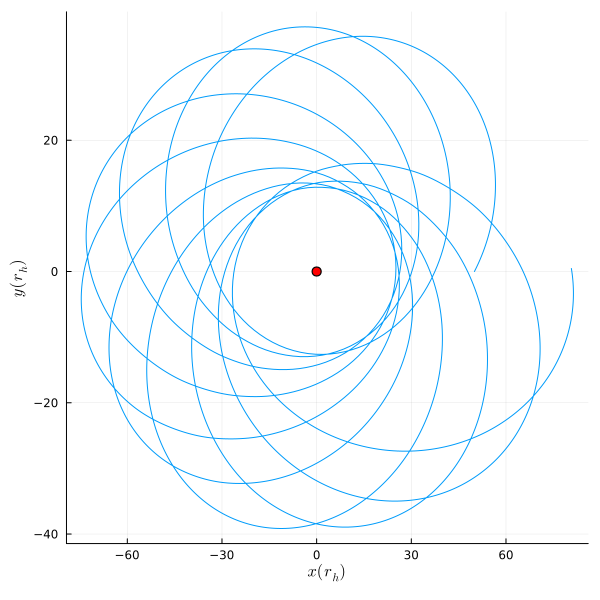

Plotting the solution generated with the following user defined parameters
-------------------------------


In [21]:
PlotTrajectory(solution,model,[1,2])

## Flexible number format

How do the two solutions compare 

In [57]:
using StochasticRounding

In [58]:
a = Float32sr(1.0)

Float32sr(1.0)

In [76]:
b = Float32(1.0)

1.0f0

In [77]:
typeof(b)

Float32

In [59]:
solutionF64,modelF64 = orbit(NF=Float64);
solutionF32,modelF32 = orbit(NF=Float32);
solutionF32_SR, modelF32_SR = orbit(NF=Float32sr);

MethodError: MethodError: no method matching decompose(::Float32sr)
Closest candidates are:
  decompose(!Matched::Integer) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/float.jl:642
  decompose(!Matched::Rational) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/rational.jl:515
  decompose(!Matched::FixedPointNumbers.Normed) at ~/.julia/packages/FixedPointNumbers/HAGk2/src/normed.jl:296
  ...

In [63]:
solutionF32[4,:]

247-element Vector{Float32}:
  0.0
  1.7575444f-6
  5.6389863f-6
  1.3662512f-5
  3.2470198f-5
  9.108698f-5
  0.00022380725
  0.0005002184
  0.0012354294
  0.0027140812
  ⋮
 62.458786
 62.575695
 62.701324
 62.84836
 63.01773
 63.281425
 63.590855
 64.0254
 64.442604

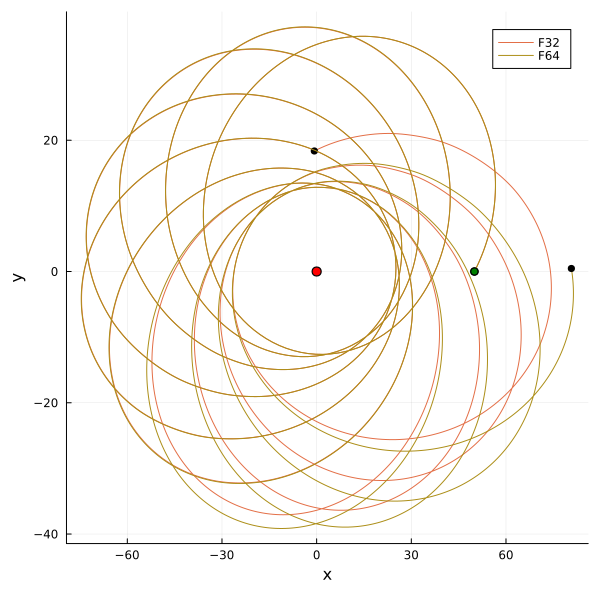

In [54]:

import Parameters: @unpack
@unpack a = modelF64.parameters    #Get the BH spin parameter 

#Interpolate to higher resolution for smooth plotting   
interpolation_factor = 10 

Tend = min(last(solutionF64.t),last(solutionF32.t))
len = length(solutionF64.t)*interpolation_factor

Tspan = range(first(solutionF64.t),Tend,length=len)
p64  = solutionF64(Tspan)
p32  = solutionF32(Tspan)

xBH = 0:0; yBH = 0:0
plt = scatter(xBH, yBH,markercolor="red",markersize=5,size = (600, 600),xlabel='x', ylabel='y',label="")

labels = ["F32", "F64"]
i = 1
for p in [p32,p64]

    r = p[2,:]
    θ = p[3,:] 
    ϕ = p[4,:]

    # Boyer lindquist to Cartesian 
    w = sqrt.(r.^2 .+ a^2) 
    x = w .* sin.(θ) .* cos.(ϕ)
    y = w .* sin.(θ) .* sin.(ϕ)
    z = r .* cos.(θ)


    plt = plot!(x,y,label=labels[i])       
    plt = scatter!(first(x):first(x), first(y):first(y),markercolor = "green",label="")
    plt = scatter!(last(x):last(x), last(y):last(y),markercolor = "black",label="")
    i+=1

end 
display(plt)


## Differentiation using Zygote.jl

`RelativisticDynamics.jl` is written so as to be generally differentiable by the [differentiation tools in Julia](https://juliadiff.org/).

Specifically, we have been working using [Zygote.jl](https://fluxml.ai/Zygote.jl/latest/).

Let's see how this works by trying to see how the orbit varies with eccentricity, i.e. we want to calculate

$$\frac{\partial L}{\partial e} $$

where $L$ is some loss function that depends on the output of `orbit()`, which we will define below.


First we need to define a reference solution against which gradients can be calculated:


In [22]:
# Get a reference solution.
# We will use this to define a gradient 
reference_solution,reference_model = orbit(Norbits=1); #using the default parameters

...and then a loss function. Here we are just using some arbitrary loss that compares the difference in the final value of the $r$-coordinate at the end of the integration.

In [23]:
function loss_function(reference,e)

    # Run the model using the new value of e
    solution,model = orbit(e=e,Norbits=1)
    

    r0 = last(reference[2,:])  # The last r value of the reference solution
    r = last(solution[2,:])    # The last r value of the new solution
    loss = abs(r0 - r)         # Loss
  
    return loss

end

loss_function (generic function with 1 method)

We can explore explicitly how this loss function varies with $e$:

In [24]:
N = 20 #number of samples
loss_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))

    loss = loss_function(reference_solution,v)
    loss_data[i,1] = v 
    loss_data[i,2] = loss

end

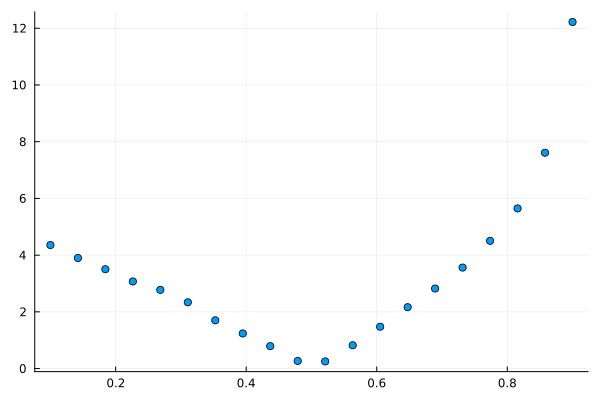

In [25]:
using Plots 
scatter(loss_data[:,1], loss_data[:,2],legend=false) # eccentricity vs loss 

Ok that makes sense - the loss is minimal at $e=0.5$ which is the value used in the reference solution and then diverges at low/high $e$.

Now, can we also get the gradient of this curve using `Zygote.jl`?

Yes! We just need to change one line from above:

In [26]:
using Zygote 

loss_gradient_data = zeros(Float64,N,2)
for (i,v) in pairs(range(0.1,0.9,N))
    loss_g = Zygote.gradient(x -> loss_function(reference_solution,x),v)[1]
    loss_gradient_data[i,1] = v 
    loss_gradient_data[i,2] = loss_g
end

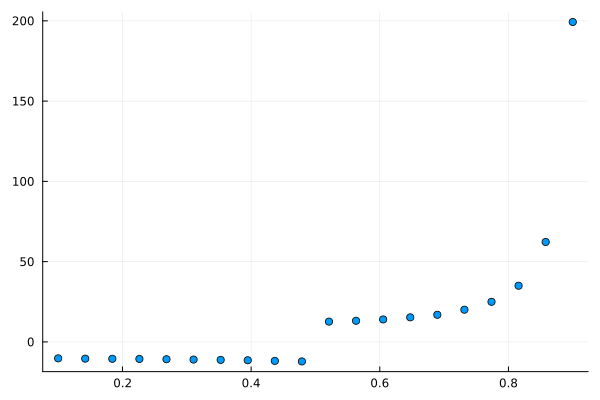

In [27]:
scatter(loss_gradient_data[:,1], loss_gradient_data[:,2],legend=false) # eccentricity vs gradient 

In [ ]:
I have been playing with Julia for some numerical orbital dynamics in GR (https://github.com/tomkimpson/RelativisticDynamics.jl), trying to use some of the techniques/concepts I learned from you + SpeedyWeather.jl. 

In [81]:
using DifferentialEquations
using StochasticRounding
f = (u,p,t) -> (p*u)
prob_ode_linear = ODEProblem(f,Float32sr(1.0)/Float32sr(2.0),(Float32sr(0.0),Float32sr(1.0)),Float32sr(1.01));
sol =solve(prob_ode_linear,Tsit5())


MethodError: MethodError: no method matching Float32sr(::BigFloat)
Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/rounding.jl:200
  (::Type{T})(::T) where T<:Number at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/boot.jl:770
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number} at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/char.jl:50
  ...

In [73]:
prob = prob_ode_linear
sol =solve(prob,Tsit5())
println(sol)

MethodError: MethodError: no method matching Float32sr(::BigFloat)
Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/rounding.jl:200
  (::Type{T})(::T) where T<:Number at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/boot.jl:770
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number} at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/char.jl:50
  ...

In [71]:
sol

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 5-element Vector{BigFloat}:
 0.0
 0.09964258706516002757241113786493079821949560824572094442904017056206815655027755
 0.3457024247583421308145661100153752226739293846153111762313695785692066646211486
 0.6776921908052248538004732061437054858600791539496176542941317413488563178090448
 1.0
u: 5-element Vector{BigFloat}:
 0.5
 0.5529386811510169905121549222942681803517017137036250612133811084046740072664042
 0.7089376245893467829092172805583925956947513313925386404738921107616392796707356
 0.9913594502399245078379256583106538498562594798883926568710576464510438939970478
 1.372800440903305274187428016868058103324428725450247680936213844886721036701333

In [66]:
using DoubleFloats


ArgumentError: ArgumentError: Package DoubleFloats not found in current path:
- Run `import Pkg; Pkg.add("DoubleFloats")` to install the DoubleFloats package.


In [67]:
]add DoubleFloats

ErrorException: syntax: unexpected "]"